<a href="https://colab.research.google.com/github/kworathur/CV-Capstone/blob/main/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

In [ ]:
from google.colab import files
files.upload() # Upload your kaggle API Key

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keshavworathur","key":"525a7f6c30bb7e288d40bf6600c4074c"}'}

# Install Python packages and download dataset

In [ ]:
!pip install tensorflow
!pip install mat73
!pip install hdf5storage
!pip install opencv-python
!pip install gdown
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

# Create the directories for original data
!rm -rf ./dataset/
!kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset
!unzip figshare-brain-tumor-dataset.zip > /dev/null



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.4 MB/s eta 0:00:00
100% 838M/839M [00:36<00:00, 23.8MB/s]
100% 839M/839M [00:36<00:00, 24.4MB/s]


In [ ]:
# Download helper script hosted in google drive
!gdown https://drive.google.com/uc?id=1RFcC9qAiBl5Bv07wRD6HGRk_BBi1lU98

Downloading...
From: https://drive.google.com/uc?id=1RFcC9qAiBl5Bv07wRD6HGRk_BBi1lU98
To: /content/matlab_to_numpy.py
100% 3.06k/3.06k [00:00<00:00, 16.1MB/s]


In [ ]:
%run -i 'matlab_to_numpy.py' ./dataset/
%reset -f

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy, patient_ids saved in ./dataset/


In [ ]:
import gc
gc.collect()

0

# Import Python Modules

In [ ]:
import os
from PIL import Image
from mat73 import loadmat

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# to perform subject-wise cross validation
from sklearn.model_selection import GroupKFold, train_test_split
import cv2

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load images, masks and labels

In [ ]:
labels = np.load('./dataset/labels.npy')
images = np.load('./dataset/images.npy', mmap_mode='r')
masks = np.load('./dataset/masks.npy', mmap_mode='r')
patient_ids = np.load('./dataset/patient_ids.npy').flatten()
file_paths = np.load('./dataset/file_paths.npy')

In [ ]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

# Data Visualization



*   Adapted from https://github.com/guillaumefrd/brain-tumor-mri-dataset/tree/master
*   Class distribution
*   2D images with tumor slices
*   Different types of brain tumors: glioma, meningioma, pituitary





## Number of examples per class

number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


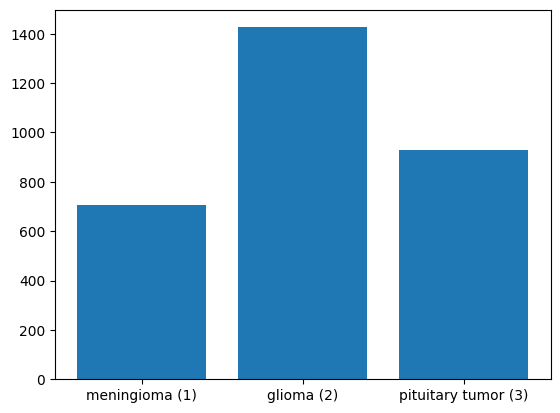

In [ ]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts,
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'])

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

## Visualize slices with tumor masks

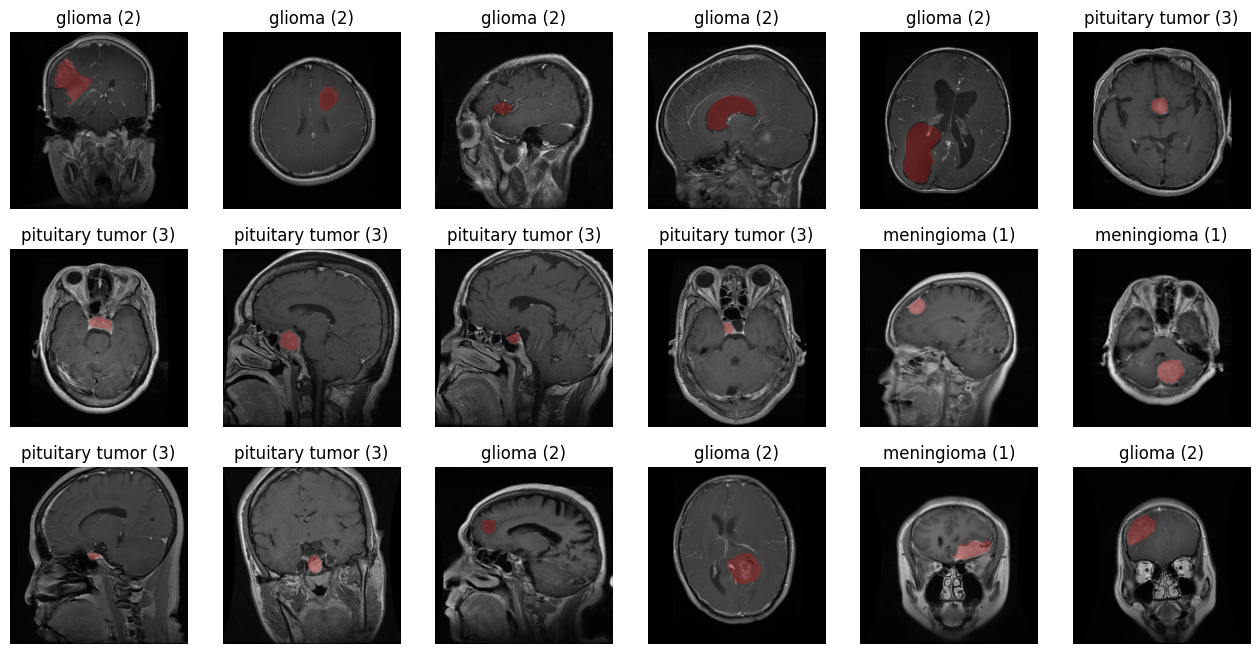

In [ ]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')

    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.3, cmap='Set1')

    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

## Crop the images to the tumor region

In [ ]:
def get_bounding_box(mask):
    """
    Return the bounding box of a mask image.
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=10):
    """
    Crop an image to the bounding by forcing a squared image as output.
    """
    x1, y1, x2, y2 =  bbox

    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])

    return image[y1:y2, x1:x2]

In [ ]:
from IPython.display import display, clear_output

dim_cropped_image = 224

images_cropped = []

for i in range(images.shape[0]):
    if i % 10 == 0:
        # print the pourcentage of images processed
        clear_output(wait=True)
        display('[{}/{}] images processed: {:.1f} %'
                .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

    bbox = get_bounding_box(masks[i])
    image = crop_to_bbox(images[i], bbox, 20)
    image = cv2.resize(image, dsize=(dim_cropped_image, dim_cropped_image),
                       interpolation=cv2.INTER_CUBIC)
    images_cropped.append(image)

clear_output(wait=True)
display('[{}/{}] images processed: {:.1f} %'
        .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

'[3064/3064] images processed: 100.0 %'

In [ ]:
images_cropped = np.array(images_cropped)
print(len(set(patient_ids)))
print(images_cropped.shape)

233
(3064, 224, 224)


## Visualize tumors

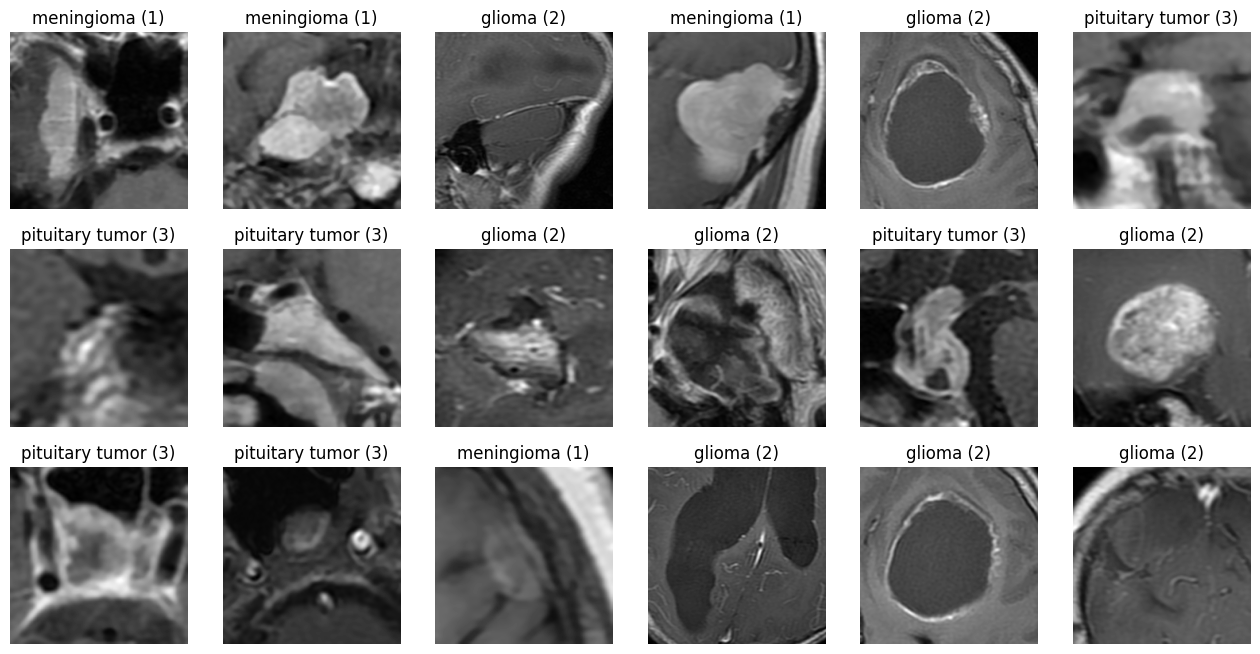

In [ ]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images_cropped[idx], cmap='gray')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

In [ ]:
max_val = 0
for idx in np.random.randint(images.shape[0], size=images.shape[0]):
  max_val = max(max_val, images[idx].max())
  print(str(images[idx].max()) + ", ", end="")

print(f"\nMax pixel value: {max_val}")

2623, 708, 3059, 1821, 797, 3801, 5392, 741, 903, 1456, 1444, 6554, 1714, 8933, 12230, 1002, 5100, 4666, 3673, 5647, 8713, 1157, 10036, 3834, 4355, 1189, 701, 6886, 2955, 3110, 1109, 622, 2405, 868, 1189, 3230, 8407, 2098, 7374, 4073, 12185, 4673, 4136, 1926, 3406, 6523, 4136, 4498, 3074, 6174, 8346, 5280, 2039, 1084, 2685, 3780, 816, 3022, 2922, 2779, 663, 2088, 2896, 4886, 6168, 831, 775, 4196, 3327, 2042, 2194, 10494, 721, 2479, 733, 2500, 2942, 817, 1153, 4399, 2866, 2608, 779, 8676, 5907, 2481, 2718, 868, 5280, 4566, 2643, 5628, 2995, 635, 2971, 903, 861, 1027, 803, 2299, 2237, 3694, 5439, 6402, 4411, 1543, 2120, 6106, 4970, 10584, 902, 2248, 3673, 5735, 11873, 1769, 2560, 3953, 891, 1656, 4136, 1008, 689, 3581, 1244, 3542, 1091, 910, 3718, 2400, 3624, 860, 904, 4447, 2827, 2402, 4455, 5132, 6780, 3035, 933, 4441, 2919, 266, 6886, 771, 635, 3199, 2646, 2458, 4642, 3126, 1001, 1628, 4401, 943, 6033, 796, 3144, 4270, 4205, 4461, 2584, 3970, 3557, 2783, 4379, 1853, 772, 5617, 2791, 3

# Create dataset splits




## One test

To test our implementation quickly we used the following split, without considering patient IDs: 60% of examples are placed in the training dataset, 20% are placed in the validation dataset, and the remaining 20% are used for the test set.

In [ ]:
X, X_test, y, y_test = train_test_split(file_paths, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)


train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## Subject-Wise Cross Validation

With subject-wise cross validation, we ensure that a patient's scans do not appear in both the training and test sets. We split the dataset into **folds**,
where each fold has roughly the same number of unique patients. The function
`assign_folds_custom` picks six folds for training, 2 for validation, and 2 for testing. `assign_folds_custom` is designed to be called in a loop, to return a new (train_set, valid_set, test_set) combination on each iteration.

In [ ]:
# Each patient is limited to appearing in one fold. The number of distinct
# patients in each fold is apporximately the same
group_kfold = GroupKFold(n_splits=10)

# A list of lists, where each sublist represents the indices corresponding to a
# single fold
folds = [indices for (_, indices) in group_kfold.split(file_paths, labels,
                                                       patient_ids)]

# Take 2 folds for test, 2 for validation, 6 for training
def assign_folds_custom(iter=0):

  train_indices = np.array([], dtype=np.int16)
  val_indices = np.array([], dtype=np.int16)
  test_indices = np.array([], dtype=np.int16)

  i = iter * 2
  for _ in range(6):
    train_indices = np.append(train_indices, folds[i])
    i = (i + 1) % len(folds)


  for _ in range(2):
    val_indices = np.append(val_indices, folds[i])
    i = (i + 1) % len(folds)

  for _ in range(2):
    test_indices = np.append(test_indices, folds[i])
    i = (i + 1) % len(folds)


  train_ds = tf.data.Dataset.from_tensor_slices((file_paths[train_indices], labels[train_indices]))
  val_ds = tf.data.Dataset.from_tensor_slices((file_paths[val_indices], labels[val_indices]))
  test_ds = tf.data.Dataset.from_tensor_slices((file_paths[test_indices], labels[test_indices]))

  return (train_ds, val_ds, test_ds)



## Report on balance of classes in each of the datasets

In [ ]:
num_classes = 3
def summarize_dataset(ds, name):

    count = np.zeros(num_classes, dtype=np.int32)
    for _, label in ds:
      count[label.numpy() - 1] += 1

    total = np.sum(count)

    label_stats = ""

    for (id_, label) in integer_to_class.items():
      label_stats += "{} {}\n".format(integer_to_class[id_], count[int(id_) - 1])

    print(f"Distribution of labels for {name}")
    print(label_stats)
    return

if train_ds is not None:
  summarize_dataset(train_ds, "Training Dataset")
  summarize_dataset(val_ds, "Validation Dataset")
  summarize_dataset(test_ds, "Test Dataset")

Distribution of labels for Training Dataset
meningioma (1) 439
glioma (2) 834
pituitary tumor (3) 565

Distribution of labels for Validation Dataset
meningioma (1) 138
glioma (2) 295
pituitary tumor (3) 180

Distribution of labels for Test Dataset
meningioma (1) 131
glioma (2) 297
pituitary tumor (3) 185



## Data Preprocessing and Performance Optimizations

* We would like to resize every image to 256 $\times$ 256 before passing it into
the model.
* We also wish to load our dataset in batches, as loading the entire dataset at once would overwhelm the memory resources in Google Colab.
* Lastly, the scalar-valued targets need to be converted to one-hot vectors.

In [ ]:
batch_size = 16 # Minibatch size
buffer_size= 512 # Sample mini-batches from a subset of the dataset


def read_image(path):
  """
    Return a 2D tensor reprensenting the pixels of the image located at <path>
  """
  img_shape=(512, 512)
  path_str = path.numpy().decode('UTF-8')
  image_data = images[np.where(file_paths == path_str)].reshape(img_shape)
  tensor = tf.convert_to_tensor(image_data)
  return tensor


def convert_to_onehot(ds):
  """
    Convert each scalar valued target in ds to a vector of shape
    [num_classes, 1]
  """
  I = tf.eye(num_classes, dtype=tf.int16)

  ds = ds.map(lambda x, y: (x, tf.py_function(lambda y: I[y.numpy() - 1], [y], [tf.int16])))
  ds = ds.map(lambda x, y: (x, tf.reshape(y, [3])))
  return ds


### Augmentation Operations ###

def add_noise(image):
  image = tf.cast(image, tf.float32)
  noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1, dtype=tf.float32)
  noisy_img = image + noise
  return noisy_img

def rotate90(img):
  return tf.image.rot90(img)

def flip_vertical(img):
  return tf.image.flip_up_down(img)


def prepare(ds, shuffle=False, augment=False):
  """
    Prepare the dataset by:
      1) Applying a function to the dataset that will load and store <batch_size>
         images in memory at a time, to avoid exceeding RAM quota
      2) If augment=True, the dataset is augmented by performing a 90 deg
         rotation of each image and a flip along the horizontal axis.
  """

  # load images from disk only when needed
  ds = ds.map(lambda x, y: (tf.py_function(read_image, [x], [tf.int16]), y))
  ds = ds.map(lambda x, y: (tf.reshape(x, (512, 512, 1)), y))
  ds = convert_to_onehot(ds)

  orig_cardinality = ds.cardinality().numpy()

  if augment:
    ds_rot = ds.map(lambda x, y: (rotate90(x), y))
    ds_flip = ds.map(lambda x, y: (flip_vertical(x), y))
    ds = ds.concatenate(ds_rot)
    ds = ds.concatenate(ds_flip)

  if shuffle:
    ds = ds.shuffle(buffer_size)

  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size)
  return ds


train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds, shuffle=True, augment=False)
test_ds = prepare(test_ds, shuffle=True, augment=False)


In [ ]:
resize = keras.Sequential([
keras.layers.Resizing(256, 256)
])


normalize = keras.layers.Normalization(axis=(1, 2))
adapt_data = train_ds.map(lambda x, y: resize(x))
normalize.adapt(adapt_data)

# Model Implementation

TODO: Brief description of the model's architecture.







In [ ]:
# Following structure of model detailed in paper:
# https://1drv.ms/u/s!AgLc-zP7ijxBkxNDdJDtxq4_xmt0
model = keras.Sequential()

### Pre-Processing Layer ###
model.add(keras.Input(shape=(512, 512, 1)))
model.add(keras.layers.Resizing(256, 256))
model.add(normalize)

### Classification Block A ###

# Layers 2 and 3
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'))

# Layer 4 - Dropout
model.add(keras.layers.Dropout(0.5))

# Layer 5 - Max Pooling
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Layer 6, 7 - Convolutional, ReLU
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))

# Layer 8 - Dropout
model.add(keras.layers.Dropout(0.5))

# Layer 9 - Max Pooling
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Layer 10, 11 - Convolutional, ReLU
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# Layer 12 - Dropout
model.add(keras.layers.Dropout(0.5))

# Layer 13 - Max Pooling
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Layer 14, 15 - Convolutional, ReLU
model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# Layer 16 - Dropout
model.add(keras.layers.Dropout(0.5))

# Layer 17 - Max Pooling
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Flattening output
model.add(keras.layers.Flatten())

# Layer 18, 19 - Fully Connected, ReLU
model.add(keras.layers.Dense(2048, activation='relu'))

# Layer 20, 21 - Fully Connected, Softmax
model.add(keras.layers.Dense(units=3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 256, 256, 1)       0         
                                                                 
 normalization (Normalizati  (None, 256, 256, 1)       131073    
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      416       
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)       

In [ ]:
gc.collect()

output_directory = "/content"
model_filename = "best_model.h5"
model_path = os.path.join(output_directory, model_filename)

if os.path.exists(model_path):
    # Remove the existing model file
    os.remove(model_path)
    print(f"Existing model file '{model_filename}' has been removed.")
else:
    print(f"No existing model file '{model_filename}' found in the directory.")

Existing model file 'best_model.h5' has been removed.


## Training: One-Test

In [ ]:
# Define a callback to save the model with the lowest validation loss

def train_once(train_ds, val_ds, test_ds, epochs=100):

  model_checkpoint = keras.callbacks.ModelCheckpoint("/content/best_model.h5",
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    monitor="val_loss",
                                                    mode="min", verbose=1)


  # Adapt the normalization layer of the model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0004), loss='categorical_crossentropy', metrics=['accuracy'])

  # Define a callback for early stopping
  early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=11,
                                                mode="min", verbose=1 if epochs % 10 == 0 else 0)

  # Training configuration
  epochs = 100  # You can adjust the number of epochs

  # Train the model with callbacks
  history = model.fit(
      x=train_ds,  # Provide the input data directly from the dataset
      epochs=epochs,
      validation_data=val_ds,
      callbacks=[model_checkpoint, early_stopping]
  )

  return history



In [ ]:
history = train_once(train_ds, val_ds, test_ds)

In [ ]:
best_train_acc = max(history.history['accuracy'])
best_valid_acc = max(history.history['val_accuracy'])


print(f"Best Training Accuracy: {best_train_acc}")
print(f"Best Validation Accuracy: {best_valid_acc}")

metrics = model.evaluate(x=test_ds, return_dict=True)
test_accuracy = metrics['accuracy']

print(f"Final Test Accuracy: {test_accuracy}")

## Training: Subject-Wise 10-Fold Cross Validation

In [ ]:

avg_accuracy = 0
for trial in range(5):
  print(f"=== Trial {trial} ===")
  (train_ds, val_ds, test_ds) = assign_folds_custom(iter=trial)


  train_ds = prepare(train_ds, shuffle=True, augment=True)
  val_ds = prepare(val_ds, shuffle=True, augment=False)
  test_ds = prepare(test_ds, shuffle=True, augment=False)



  history = train_once(train_ds, val_ds, test_ds, epochs=35)

  best_train_acc = max(history.history['accuracy'])
  best_valid_acc = max(history.history['val_accuracy'])


  print(f"Best Training Accuracy: {best_train_acc}")
  print(f"Best Validation Accuracy: {best_valid_acc}")

  metrics = model.evaluate(x=test_ds, return_dict=True)
  test_accuracy = metrics['accuracy']

  print(f"Final Test Accuracy: {test_accuracy}")
  avg_accuracy += test_accuracy
  gc.collect()

print(f"Average Test Accuracy: {avg_accuracy}")

In [ ]:
model_path = "/content/best_model.h5"
if os.path.exists(model_path):
    print("Model file exists.")
else:
    print("Model file does not exist.")

Model file exists.


In [ ]:
gc.collect()

876

## Load the Trained Model

In [ ]:
# Load the best model
best_model = keras.models.load_model("/content/best_model.h5")

# Results

### Display Model Learning Curves




In [ ]:
# # Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### Display Model Confusion Matrix

1/1 [==============================] - 0s 28ms/step


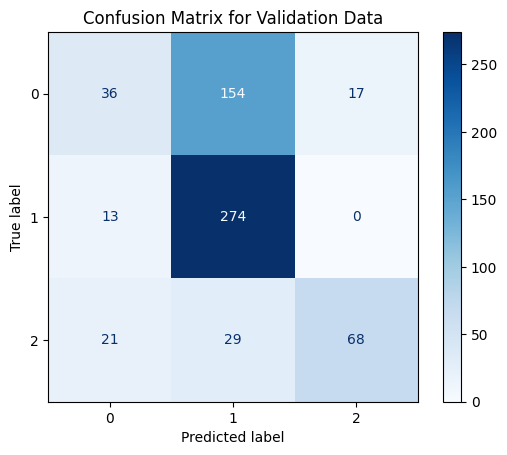

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Make predictions on the validation data and store true labels
for batch in val_ds:
    val_images, val_labels = batch
    val_predictions = best_model.predict(val_images)
    true_labels.extend(np.argmax(val_labels, axis=1))
    predicted_labels.extend(np.argmax(val_predictions, axis=1))

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
labels = [str(i) for i in range(confusion.shape[0])]
disp = ConfusionMatrixDisplay(confusion, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format=".4g")

plt.title('Confusion Matrix for Validation Data')
plt.show()

In [ ]:
gc.collect()

3352

1/1 [==============================] - 0s 21ms/step


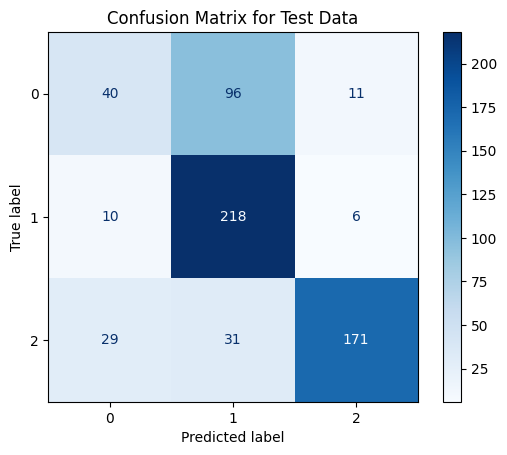

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the best model
# best_model = keras.models.load_model("/content/best_model.h5",
#                                      custom_objects={"RandomRot90": RandomRot90})

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Make predictions on the validation data and store true labels
for batch in test_ds:
    test_images, test_labels = batch
    test_predictions = best_model.predict(test_images)
    true_labels.extend(np.argmax(test_labels, axis=1))
    predicted_labels.extend(np.argmax(test_predictions, axis=1))

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
labels = [str(i) for i in range(confusion.shape[0])]
disp = ConfusionMatrixDisplay(confusion, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format=".4g")

plt.title('Confusion Matrix for Test Data')
plt.show()

# Interpreting a Classifier's Decisions with Saliency Maps

In [ ]:
def add_gaussian_noise(image):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        # print(image.shape)
        # image = image.reshape((512, 512, 1))
        # image = best_model.layers[0](image)
        # image = best_model.layers[1](image)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=10, dtype=tf.float32)
        noise_img = image + noise
        # noise_img = tf.clip_by_value(noise_img, 0.0, 0.5)
    return noise_img

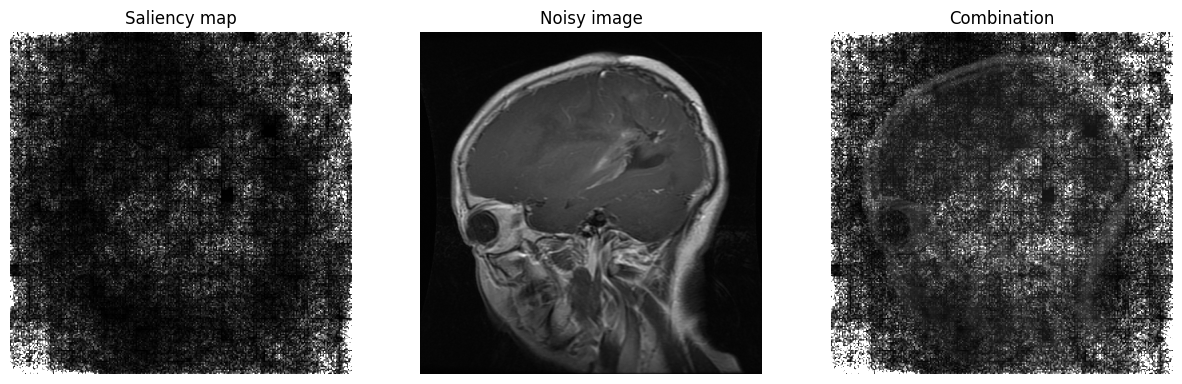

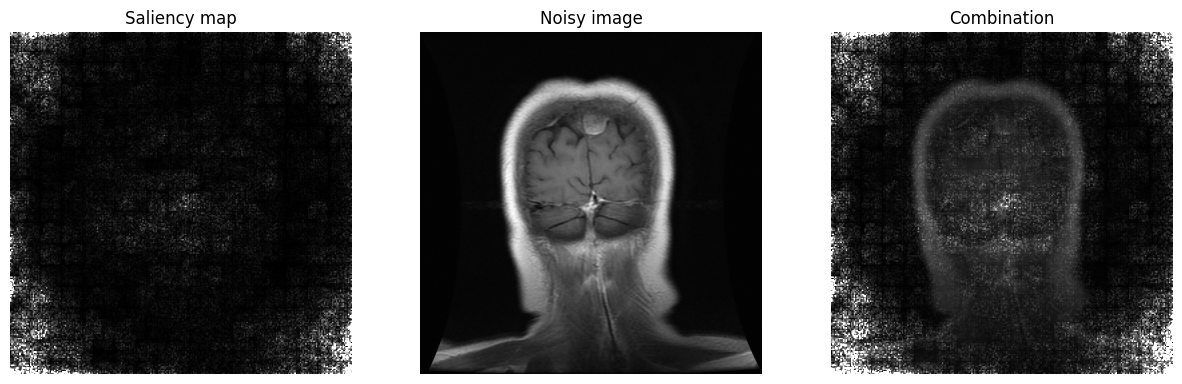

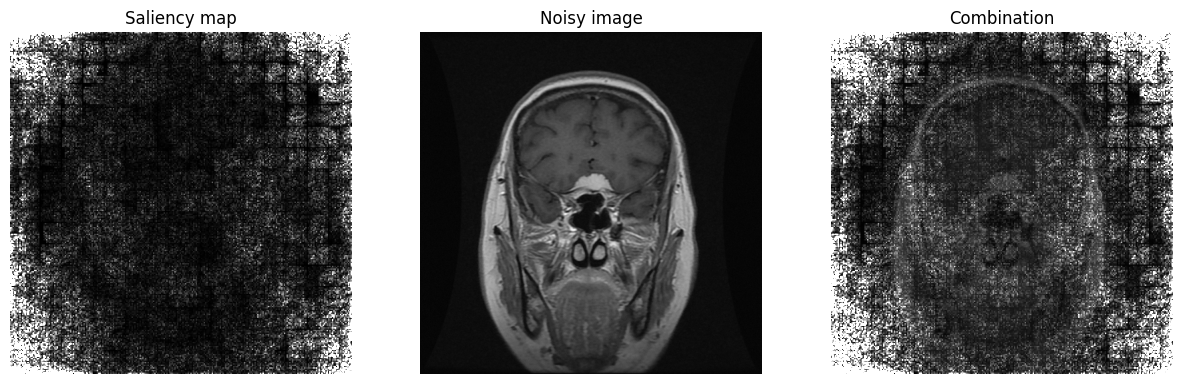

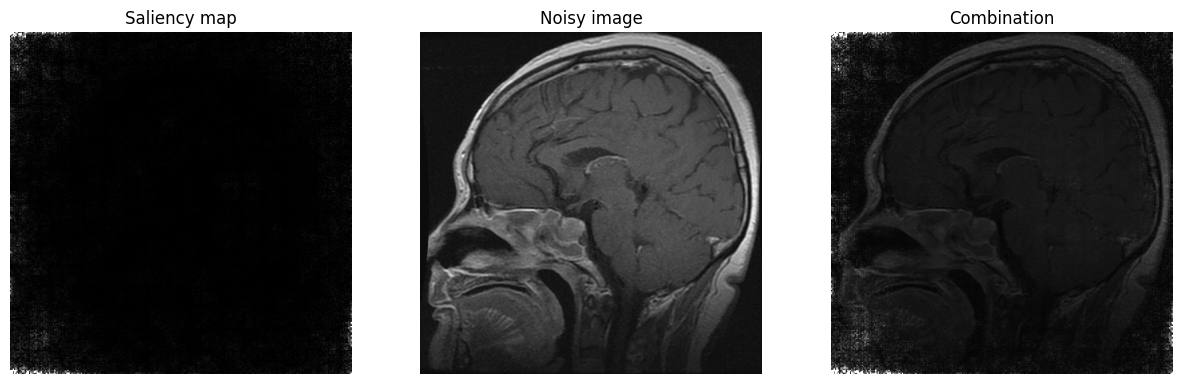

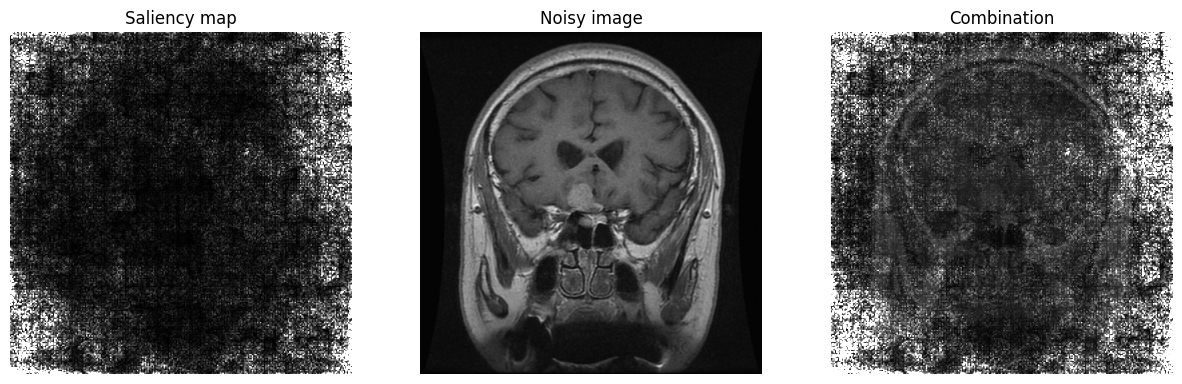

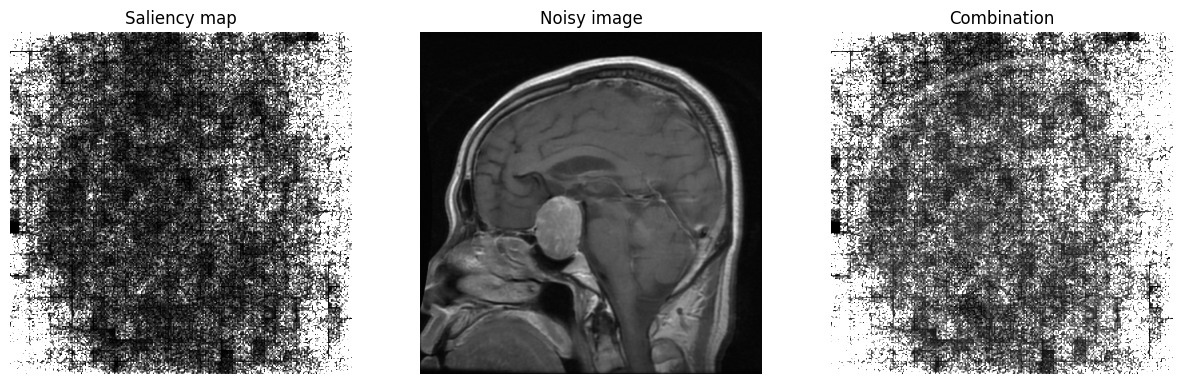

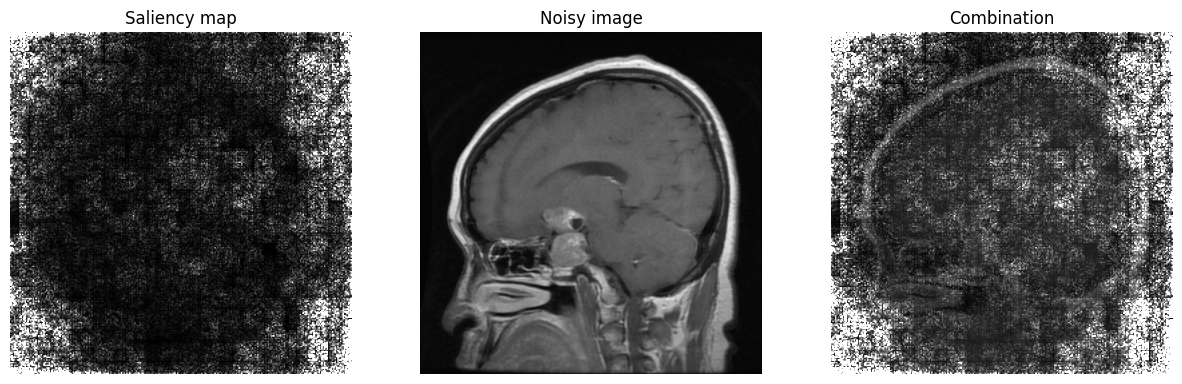

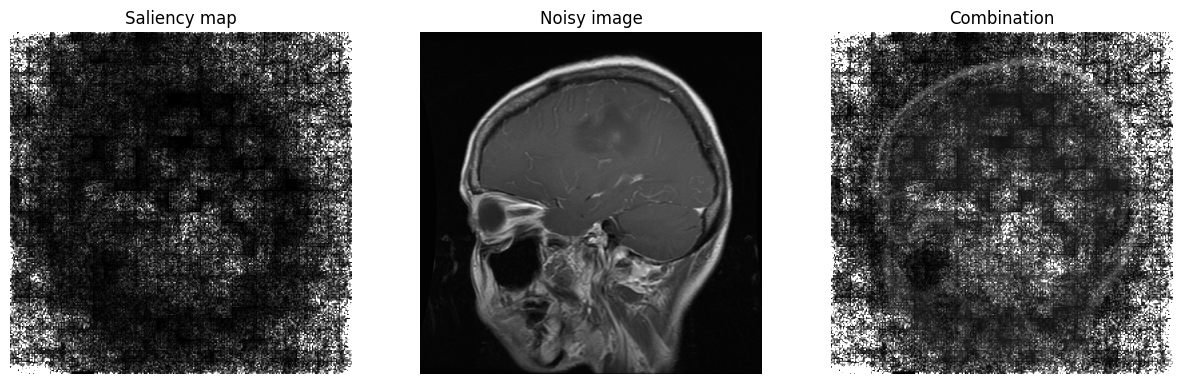

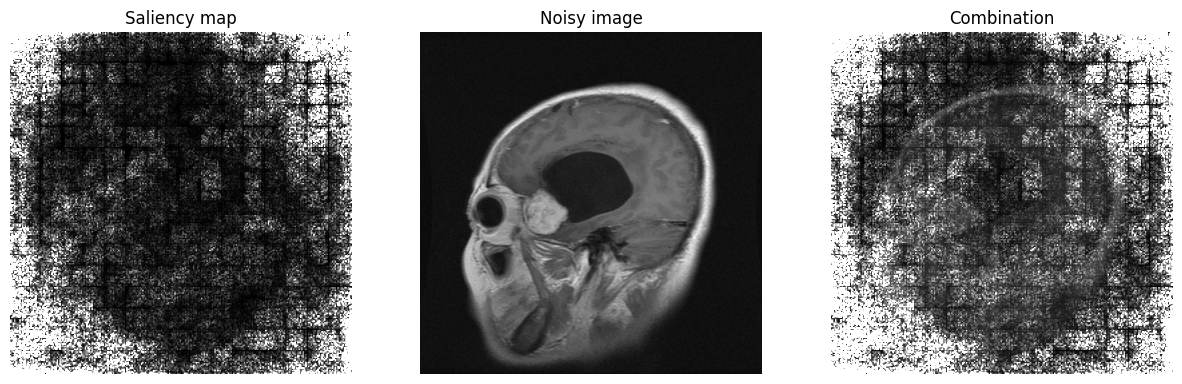

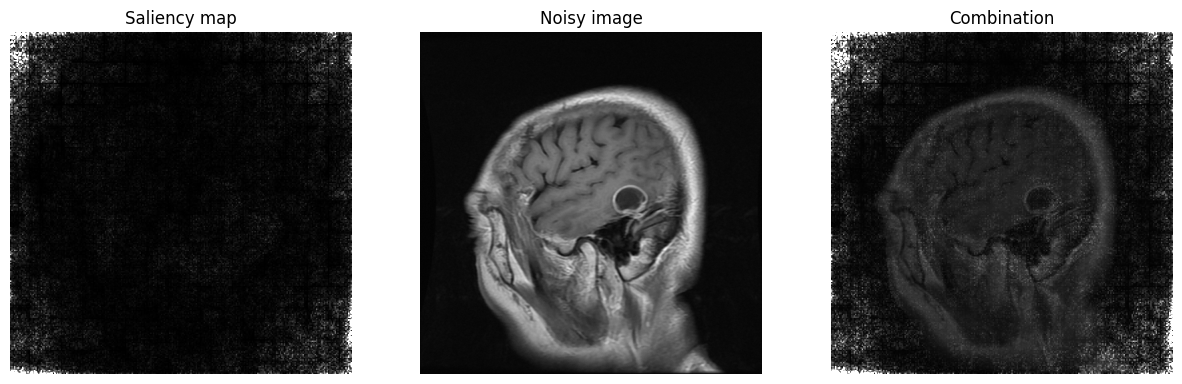

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming you have loaded images as a NumPy array
images = np.load('./dataset/images.npy', mmap_mode='r')

# Set your image size
img_size = 512
cmap = 'gray'

# Image preprocessing function for a single image
def preprocess_image(image):
    # Ensure the image has the correct number of channels (e.g., for grayscale to RGB conversion)
    if len(image.shape) == 2:  # Grayscale image
        image = np.expand_dims(image, axis=-1)
        image = np.concatenate([image, image, image], axis=-1)  # Convert to RGB by repeating the single channel

    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert image to float32
    image = tf.image.resize(image, (img_size, img_size))    # Resize the image
    return image


def get_median(v):
    v = tf.reshape(v, [-1])
    m = v.get_shape()[0]//2
    return tf.reduce_min(tf.nn.top_k(v, m, sorted=False).values)


def normalize_image(img):
    # Normalize the saliency map directly without channel-wise manipulation
    img_min = tf.reduce_min(img)
    img_max = tf.reduce_max(img)
    normalized_img = (img - img_min) / (img_max - img_min)
    return normalized_img

# Plotting function
def plot_maps(img1, img2, idx, vmin=0, vmax=10, mix_val=0.7, delta=0.5):
    f = plt.figure(figsize=(15, 45))
    plt.subplot(1, 3, 1)

    img1_flattened = tf.reshape(img1, [-1])

    # v90 = np.percentile(img1_flattened.numpy(), 90)
    # print(f"Median : {v90}")
    # vmin = v90
    # vmax = 1

    plt.title("Saliency map")
    plt.imshow(img1, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Noisy image")
    plt.imshow(img2, cmap=cmap)
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("Combination")
    plt.imshow(img1 * mix_val + img2 / mix_val, vmin=0, vmax=5, cmap=cmap)
    plt.axis("off")

# Loop through the images and generate saliency maps
counter = 0
for i in range(images.shape[0]):
    img = images[i]  # Get an image from the array
    # print(img.shape)

    # Preprocess the image
    # preprocessed_img = preprocess_image(img)
    preprocessed_img = img
    preprocessed_img = add_gaussian_noise(preprocessed_img)
    # print(preprocessed_img.shape)

    # Expand the dimensions to match model input shape (if needed)
    preprocessed_img = tf.expand_dims(preprocessed_img, axis=0)
    preprocessed_img = tf.cast(preprocessed_img, tf.float32)
    # print(preprocessed_img.dtype)

    # Generate saliency map using the loaded image and model
    with tf.GradientTape() as tape:
        tape.watch(preprocessed_img)
        predictions = best_model(preprocessed_img)
        # print(predictions)
        top_prediction = tf.argmax(predictions[0])
        top_score = predictions[:, top_prediction]

    # Get the gradients of the top prediction w.r.t. the input image
    grads = tape.gradient(top_score, preprocessed_img)
    # print(grads)
    saliency_map = tf.abs(grads)

    # Normalize the saliency map
    saliency_map = normalize_image(saliency_map.numpy())
    saliency_map *= 50


    # Normalize the image
    preprocessed_img = normalize_image(preprocessed_img)

    # Squeeze both saliency map and image
    saliency_map = tf.squeeze(saliency_map)
    preprocessed_img = tf.squeeze(preprocessed_img)

    # print(saliency_map)
    # print(labels[:20])

    plot_maps(20 * saliency_map , preprocessed_img, i)
    counter += 1
    if counter == 10:
        break

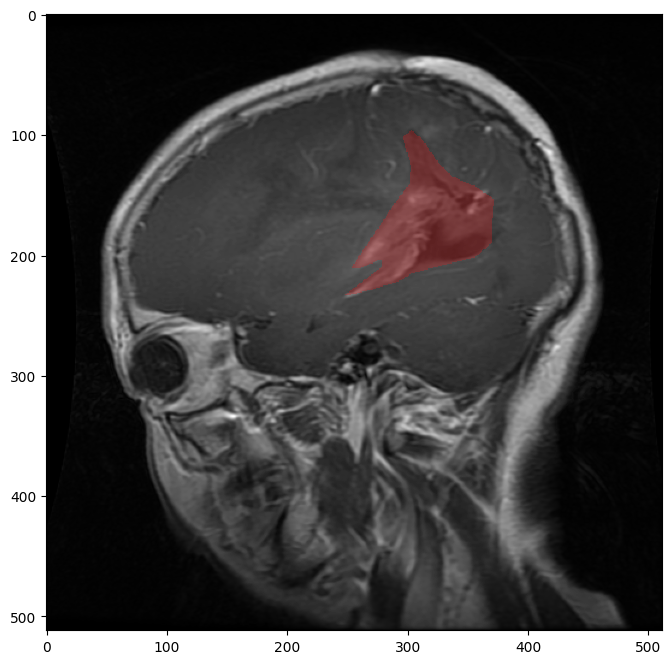

In [ ]:
plt.figure(figsize=(16, 8))
# for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
counter = 0
for i in range(images.shape[0]):
    # plt.subplot(3, 6, i)
    plt.imshow(images[i], cmap='gray')

    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[i] == False, masks[i])
    plt.imshow(mask, alpha=0.3, cmap='Set1')

    # plt.title(integer_to_class[str(labels[i])])
    # plt.axis('off')
    counter += 1
    if counter == 1:
        break

In [ ]:
# import tensorflow as tf
# import tensorflow.keras as keras

# import numpy as np
# import matplotlib.pyplot as plt

# print('tensorflow {}'.format(tf.__version__))
# print("keras {}".format(keras.__version__))

In [ ]:
i = 0
img = images[i]

# img = img.reshape((1, *img.shape))
img = tf.expand_dims(img, axis=0)
# print(img.dtype)
img = tf.cast(img, tf.float32)
y_pred = model.predict(img)

1/1 [==============================] - 0s 187ms/step


In [ ]:
images = img
print(images.shape)

with tf.GradientTape() as tape:
    tape.watch(img)
    pred = best_model(images)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]

grads = tape.gradient(loss, images)
print(grads.shape)

(1, 512, 512)
(1, 512, 512)


In [ ]:
dgrad_abs = tf.math.abs(grads)
print(dgrad_abs.shape)

(1, 512, 512)


In [ ]:
# dgrad_max_ = np.max(dgrad_abs)[0]
# dgrad_max_ = np.max(dgrad_abs, axis=1)[0]
# print(dgrad_max_)

In [ ]:
## normalize to range between 0 and 1
# arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
# grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

arr_min, arr_max  = np.min(dgrad_abs), np.max(dgrad_abs)
grad_eval = (dgrad_abs - arr_min) / (arr_max - arr_min + 1e-18)
print(grad_eval)

tf.Tensor(
[[[2.9841734e-02 2.9841734e-02 4.1951343e-02 ... 2.6480071e-03
   1.1767397e-02 1.1767397e-02]
  [2.9841734e-02 2.9841734e-02 4.1951343e-02 ... 2.6480071e-03
   1.1767397e-02 1.1767397e-02]
  [9.1373287e-02 9.1373287e-02 9.7000651e-02 ... 1.5752140e-02
   1.8021520e-02 1.8021520e-02]
  ...
  [1.5001325e-01 1.5001325e-01 4.9503233e-02 ... 3.7464432e-02
   1.7608240e-02 1.7608240e-02]
  [1.0000000e+00 1.0000000e+00 9.9725053e-02 ... 1.3647738e-01
   6.6193118e-04 6.6193118e-04]
  [1.0000000e+00 1.0000000e+00 9.9725053e-02 ... 1.3647738e-01
   6.6193118e-04 6.6193118e-04]]], shape=(1, 512, 512), dtype=float32)


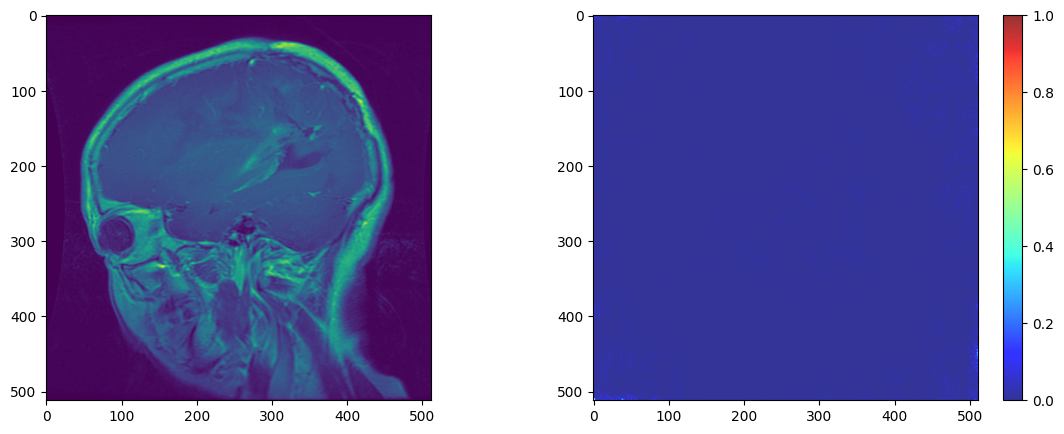

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(np.squeeze(img))
i = axes[1].imshow(np.squeeze(grad_eval),cmap="jet",alpha=0.8)
fig.colorbar(i)

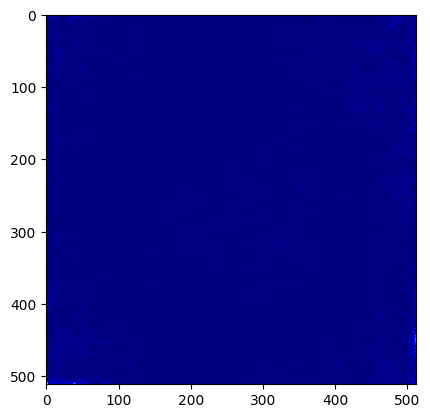

In [ ]:
plt.imshow(np.squeeze(grad_eval), cmap='jet')

In [ ]:
import numpy as np
import tensorflow as tf
import scipy.io

# Load your grayscale image from .mat file
# Assuming `input_image` contains the loaded image

# Preprocess the image for the model
# (You might need to adjust this based on your preprocessing steps)
# preprocessed_image = preprocess_image(input_image)

def compute_saliency_map(model, image):
    image = tf.convert_to_tensor(image)  # Convert the image to a TensorFlow tensor
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    # preprocessed_img = tf.expand_dims(preprocessed_img, axis=0)
    image = tf.cast(image, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)  # Forward pass to obtain predictions

        # Get the index of the predicted class (assuming binary classification)
        predicted_class = tf.argmax(predictions[0])

        # Compute the loss for the predicted class
        loss = predictions[:, predicted_class]

    # Get the gradients of the loss with respect to the input image
    gradients = tape.gradient(loss, image)
    print(gradients)

    # Compute the absolute values of the gradients
    abs_gradients = tf.abs(gradients)

    # Compute the saliency map by selecting the maximum magnitude across color channels
    # saliency_map = tf.reduce_max(abs_gradients, axis=-1)
    saliency_map = abs_gradients

    # Normalize the saliency map between 0 and 1
    saliency_map = saliency_map / tf.reduce_max(saliency_map)

    return saliency_map.numpy()  # Return the saliency map as a NumPy array


tf.Tensor(
[[[ 1.1205193e-06  1.1205193e-06  1.5752198e-06 ...  9.9429315e-08
    4.4185083e-07  4.4185083e-07]
  [ 1.1205193e-06  1.1205193e-06  1.5752198e-06 ...  9.9429315e-08
    4.4185083e-07  4.4185083e-07]
  [ 3.4309510e-06  3.4309510e-06 -3.6422516e-06 ... -5.9147288e-07
    6.7668526e-07  6.7668526e-07]
  ...
  [-5.6328076e-06 -5.6328076e-06 -1.8587837e-06 ... -1.4067419e-06
    6.6116712e-07  6.6116712e-07]
  [ 3.7548733e-05  3.7548733e-05 -3.7445493e-06 ...  5.1245529e-06
   -2.4854719e-08 -2.4854719e-08]
  [ 3.7548733e-05  3.7548733e-05 -3.7445493e-06 ...  5.1245529e-06
   -2.4854719e-08 -2.4854719e-08]]], shape=(1, 512, 512), dtype=float32)
(1, 512, 512)


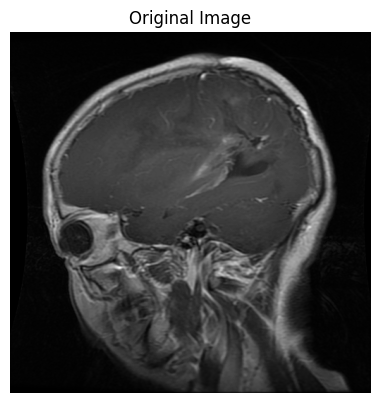

In [ ]:
img = images[0]
saliency_map = compute_saliency_map(best_model, img)
print(saliency_map.shape)

# Display the original image
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')  # Assuming it's a grayscale image
plt.title('Original Image')
plt.axis('off')

# Display the saliency map
# plt.subplot(1, 2, 2)
# plt.imshow(saliency_map[0], cmap='hot')  # Using a colormap suitable for heatmaps
# plt.title('Saliency Map')
# plt.axis('off')

plt.tight_layout()
plt.show()

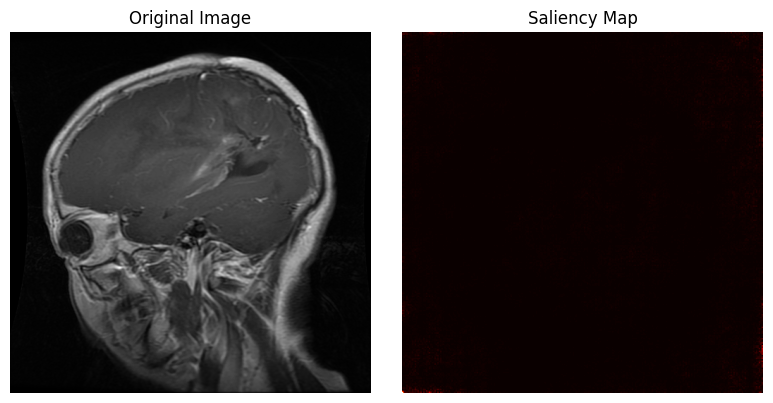

In [ ]:
import matplotlib.pyplot as plt

# Display the original image
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')  # Assuming it's a grayscale image
plt.title('Original Image')
plt.axis('off')

# Display the saliency map
plt.subplot(1, 2, 2)
plt.imshow(saliency_map[0], cmap='hot')  # Using a colormap suitable for heatmaps
plt.title('Saliency Map')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
gc.collect()

95639

## Gaussian Noise

In [ ]:
print(img)

tf.Tensor(
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  6.  5.  4.]
 ...
 [ 0.  0.  0. ...  9. 10. 13.]
 [ 0.  0.  0. ...  7.  8. 11.]
 [ 0.  0.  0. ...  4.  4.  5.]], shape=(512, 512), dtype=float32)


In [ ]:
def add_gaussian_noise(image):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        image = image.reshape((512, 512, 1))
        image = best_model.layers[0](image)
        image = best_model.layers[1](image)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=50/(255), dtype=tf.float32)
        noise_img = image + noise
        # noise_img = tf.clip_by_value(noise_img, 0.0, 0.5)
    return noise_img

AttributeError: ignored

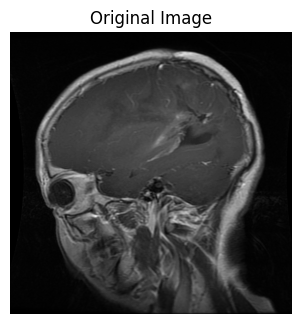

In [ ]:
img = images[0]

# Display the original image
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')  # Assuming it's a grayscale image
plt.title('Original Image')
plt.axis('off')

noisy_img = add_gaussian_noise(img)
max_ = tf.reduce_max(noisy_img)

# Display the saliency map
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(noisy_img), cmap='gray')  # Using a colormap suitable for heatmaps
plt.title('Noise-added image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(img)
print(noisy_img)
print(max_)